## 1. Using Data Augmentation to increase dataset size

Loading Training Samples...
0- [dogs] with total of 4005 samples
1- [cats] with total of 4000 samples
Loading Test Samples...
0- [dogs] with total of 1012 samples
1- [cats] with total of 1011 samples


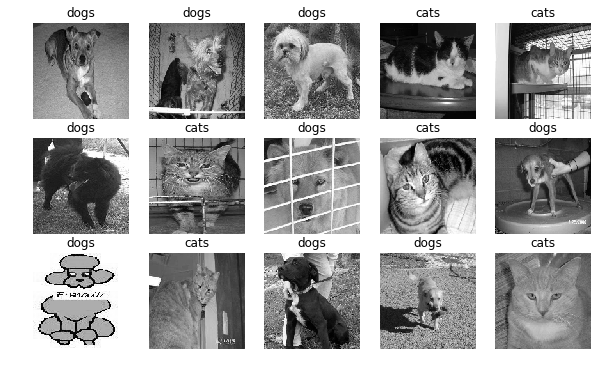

In [1]:
import numpy as np
import PML
import matplotlib.pyplot as plt
%matplotlib inline

TARGET_WIDTH=150
TARGET_HEIGHT=150

print("Loading Training Samples...")
samples,labels=PML.load_img_dataset_from_folder("datasets/catsdogs",target_size=(TARGET_WIDTH,TARGET_HEIGHT),grayscale=True)
#load test samples
print("Loading Test Samples...")
sample_test,labels_test=PML.load_img_dataset_from_folder("test/catsdogs/",target_size=(TARGET_WIDTH,TARGET_HEIGHT),grayscale=True)

PML.plot_random_images(samples,labels=labels,rows=3,cols=5)

In [2]:

from tensorflow.keras import utils
import random
import PML

#shuffle samples order
random.shuffle(samples)

#Split to input X and labels Y
X=np.array([i[0] for i in samples])
Y=np.array([i[1] for i in samples])
 
#Prepared to convolutional samples (3 channels per sample)
X=PML.prepare_conv_samples(X)
#normalize values
x_train,normalizer=PML.normalize_image(X)

#prepare labels to one-hot-encoding
nb_classes=len(labels)
y_train = utils.to_categorical(Y, nb_classes)

In [3]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

Training using: 7204 samples
Validating using: 801 samples


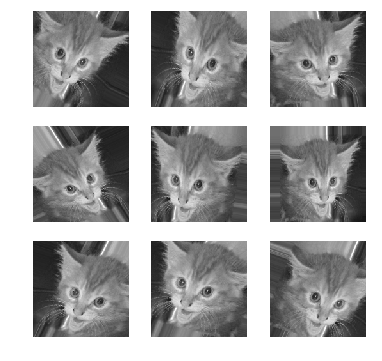

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen=ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                       height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                       horizontal_flip=True, fill_mode="nearest")

#plot some random generated images
i=1
count=3
fig=plt.figure(figsize=(count*2,count*2))
for b in gen.flow(np.array([X_train[0]]),batch_size=1):
    fig.add_subplot(count,count,i)
    plt.axis('off')
    img=plt.imshow(image.array_to_img(b[0,:,:,:]))
    i+=1
    if(i>count*count):
        break
        
plt.show()

In [ ]:

from tensorflow.keras.callbacks import TensorBoard
from time import time

input_shape=(TARGET_WIDTH,TARGET_HEIGHT,1)
BatchSize=32

model=PML.create_conv_classify_model(input_shape,nb_classes,32,[64,128,128],[256,64],dropout=0)

history=model.fit_generator(gen.flow(X_train,Y_train,batch_size=BatchSize),validation_data=(X_test,Y_test),epochs=20,
                            steps_per_epoch=100)

#export model
PML.export_model(model,"./models/catsdogs")

/Users/yamen/Documents/GitHub/PracticalML/6. Advance ML/Python/PML.py:320: RuntimeWarning: invalid value encountered in true_divide
  channel_img/=channel_img.std()


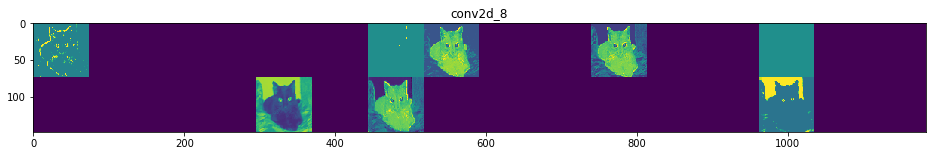

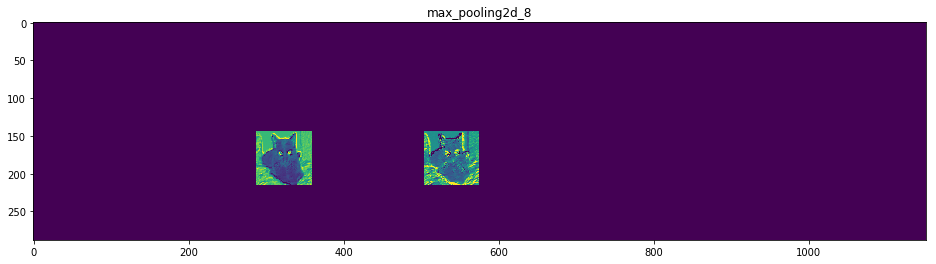

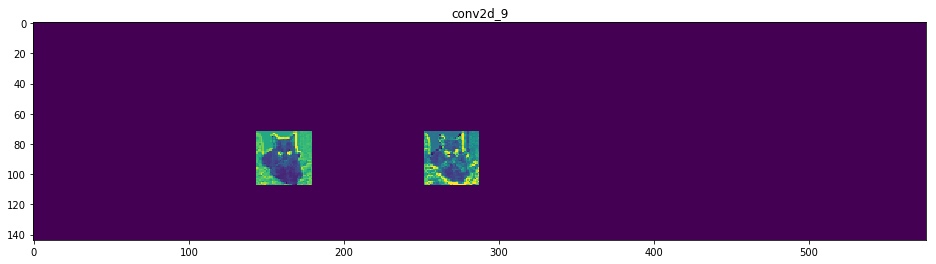

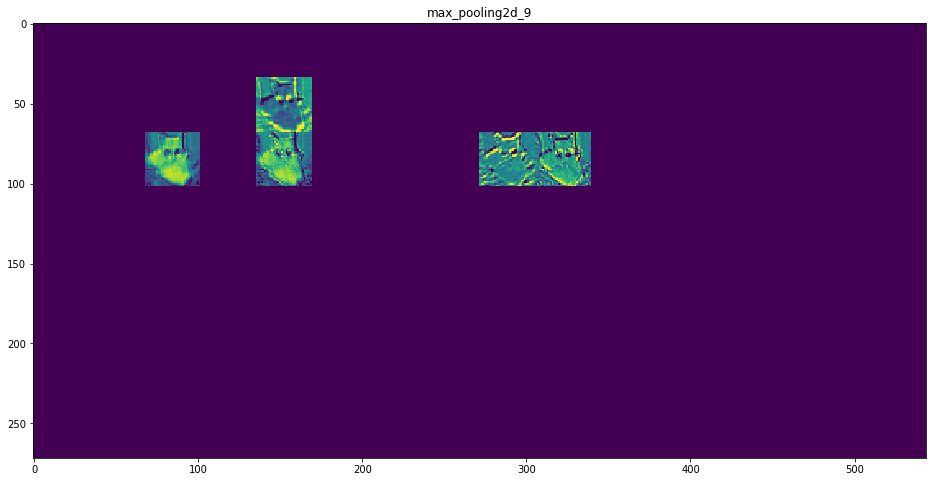

In [9]:
from importlib import reload  # Python 3.4+ only.
import PML

PML.VisualizeActivations(model,X_train[1],5)

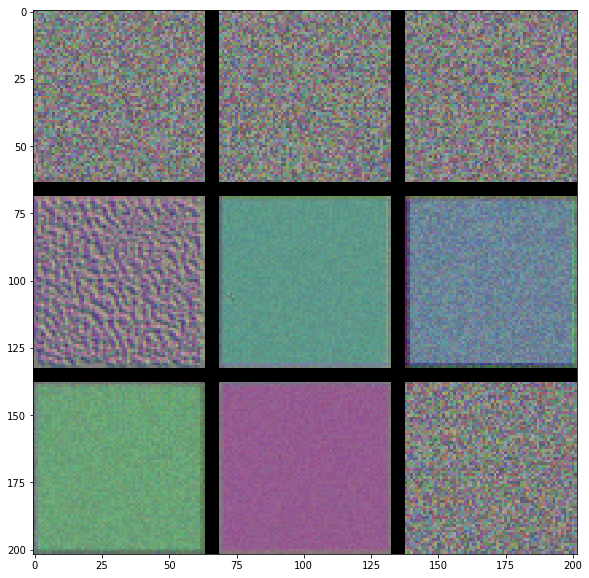

In [17]:
PML.VisualizeLayerActivation(model,'conv2d_4')

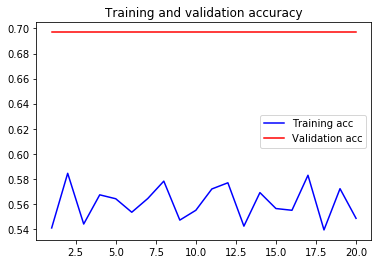

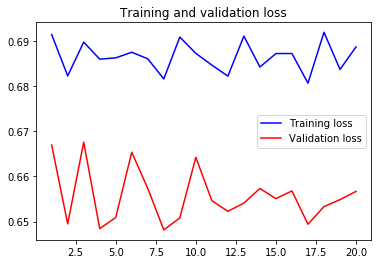

In [18]:
PML.plot_acc_loss(history)